### Initial modeling experiments

In [15]:
# Setup
import pandas as pd
from sqlalchemy import create_engine, text
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling libraries


# Connect to database using database YAML file with connection params
with open('database.yaml', 'r') as f:
    db_params = yaml.safe_load(f)

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['db'],
  user=db_params['user'],
  password=db_params['pass']    
))

In [25]:
# Read in SQL
with open('get_analysis_data.sql', 'r') as f:
    sql = f.read()

# Get data using SQL query
df = pd.read_sql(sql, engine)

In [26]:
df.head()

,parcelid,year_built,attic_sqft,bsmt_sqft,live_sqft,sqft_flr1,sqft_flr2,sqft_flrh,story_ht,prop_class_code,...,fireplaces,garage_type,garage_capacity,finished_sq_ft,total_finish_area,first_floor_area,half_floor_area,finished_basement,initial_land_value,initial_building_value
0,0500002001300,1908,0,600,1080,600,480,0,1.5,510,...,0.0,Detached-001-Frame Construction,270,600.0,1080.0,600.0,480.0,0.0,NaN,NaN
1,0490003017100,1911,337,702,1789,750,702,0,2.0,520,...,0.0,Detached-001-Frame Construction,324,750.0,1789.0,750.0,702.0,0.0,NaN,NaN
2,0490003017200,1919,320,667,1680,681,679,0,2.0,510,...,0.0,Detached-001-Frame Construction,324,681.0,1680.0,681.0,679.0,0.0,NaN,NaN
3,0490003017300,1916,346,720,1826,760,720,0,2.0,510,...,0.0,None,0,1826.0,1826.0,760.0,720.0,0.0,NaN,NaN
4,0490003017400,1909,0,792,1496,792,704,0,2.0,510,...,0.0,Detached-001-Frame Construction,200,792.0,1496.0,792.0,704.0,0.0,NaN,NaN


In [27]:
df_labeled = df[(df['initial_building_value'].isna() == False)]

print(f"There are {len(df_labeled)} labeled observations")

There are 44 labeled observations


#### Distribution of outcome variable

Distribution of initial building value
count       44.000000
mean      4907.500000
std       8600.816112
min        630.000000
25%       1967.500000
50%       3320.000000
75%       4327.500000
max      56990.000000
Name: initial_building_value, dtype: float64


[Text(0.5, 1.0, 'Histogram of initial_building_value')]

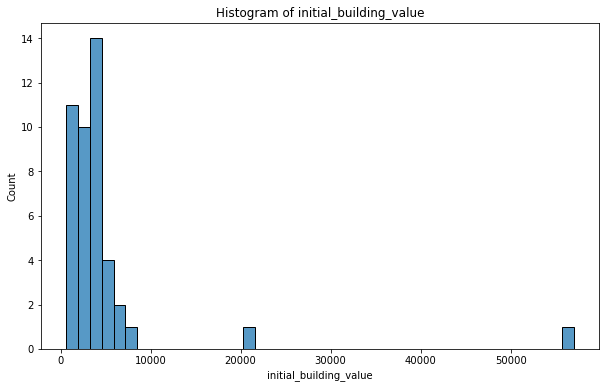

In [29]:
# Distribution of the outcome variable
print('Distribution of initial building value')
print(df_labeled['initial_building_value'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_labeled, x='initial_building_value').set(title='Histogram of initial_building_value')

In [44]:
## Correlations with other numeric variables
df_labeled.corrwith(df['initial_building_value']).sort_values()

year_built               -0.346381
sale_price               -0.146771
total_sales_records      -0.055197
number_of_parcels        -0.006152
sqft_flrh                 0.033065
appraisal_area            0.099825
attic_sqft                0.113886
story_ht                  0.239144
half_bath                 0.377836
half_floor_area           0.575422
sqft_flr2                 0.575422
full_bath                 0.579347
fireplaces                0.585936
total_rooms               0.606266
finished_basement         0.683294
garage_capacity           0.689898
total_finish_area         0.715678
live_sqft                 0.715678
sqft_flr1                 0.844025
first_floor_area          0.844025
bsmt_sqft                 0.885279
finished_sq_ft            0.949319
initial_land_value        0.961319
initial_building_value    1.000000
prop_class_code                NaN
dtype: float64

### Simple models

In [45]:
# Linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

reg = smf.ols('initial_building_value ~ year_built + finished_sq_ft + bsmt_sqft', df_labeled).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     initial_building_value   R-squared:                       0.919
Model:                                OLS   Adj. R-squared:                  0.912
Method:                     Least Squares   F-statistic:                     150.4
Date:                    Sat, 19 Nov 2022   Prob (F-statistic):           8.16e-22
Time:                            00:15:03   Log-Likelihood:                -405.38
No. Observations:                      44   AIC:                             818.8
Df Residuals:                          40   BIC:                             825.9
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -6.397e+04   4.69e+04     -1.365      0.180   -1.59e+05    3.07e+04
year_built        31.7035     24.577      1.290      0.204     -17.968      81.375
finished_sq_ft     4.0086      0.522      7.674      0.000       2.953       5.064
bsmt_sqft          3.0146      1.442      2.090      0.043       0.100       5.930
==============================================================================
Omnibus:                       19.608   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.439
Skew:                          -0.973   Prob(JB):                     4.10e-12
Kurtosis:                       7.981   Cond. No.                     3.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Do a train-test split